In [1]:
using OrdinaryDiffEq
using Plots
using Random
using Optim
using LaTeXStrings
using BenchmarkTools

rng = Xoshiro(14588); # set random number generator seed

For this notebook we will again investigate pendulum model $$\frac{\mathrm{d}}{\mathrm{d}t}x(t)=\begin{bmatrix}\dot{\theta}(t)\\ \ddot{\theta}(t)\end{bmatrix}=\begin{bmatrix}x_2(t)\\ -\frac{g}{L}\sin(x_1(t))-\frac{b}{m}x_2(t)\end{bmatrix}$$
with the states $x(t)=\begin{bmatrix}\theta & \dot{\theta} \end{bmatrix}^\mathrm{T}$ being the angular position $\theta$ and the angular velocity $\dot{\theta}$. 

In contrast to the previous [pendulum parameter identification notebook](./Nonlinear_Parameter_Identification_Pendulum.ipynb), we will identify the pendulum's length $L$ and will consider that a smaller friction coefficient is already known.


In [2]:
# Model parameters defined as constants
const g = 9.81 # gravity constant
const L = 1.0 # length of pendulum
const b = 0.025 # damping coefficient (now 1/10 of previous value)
const m = 0.5 # mass of pendulum

#Initial condition and simulation time span
const x0 = [0,π/2]
const tspan = (0.0,4)

(0.0, 4)

Again, we start with generating some noisy ground truth data. 

In [3]:
#Define the ODE model as a function which can be passed to a solver
function simplependulum!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/L)*sin(x[1]) - b/m*x[2]
    nothing
end

#Define ODE problem and solve
prob = ODEProblem(simplependulum!, x0, tspan);
sol = solve(prob,Tsit5(),saveat=0.05);

# add noise to States
t, x = sol.t, sol.u # get time and state vector
N = length(t)
σ = 0.05; # standard deviation of measurement noise
y = reduce(hcat,x) + σ*randn(2,N); # add noise to state vector

Next, we mildly modify our training model and cost function to allow identifying the pendulum's length and not the friction coefficient.

In [4]:
function simplependulum_train_length!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/p[1])*sin(x[1]) - b/m*x[2]
    nothing
end;

prob = ODEProblem(simplependulum_train_length!, x0, tspan, [1.0]);
function costs(w, y, f)
    newprob = remake(f, p = w) # create an updated ODE problem with new parameters
    sol = solve(newprob,Tsit5(),saveat=0.05)
    x = reduce(hcat,sol.u)    
    return sum(abs2.(y .- x)) # return the sum of squared errors
end;

Before solving the parameter identification problem, we will visualize the scalar cost function.

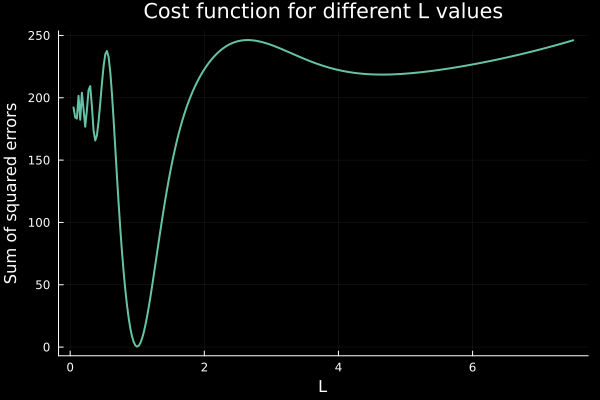

In [5]:
L_vec = LinRange(0.05, 7.5, 300) # create a vector of L values
cost_vec = zeros(length(L_vec))
for ii = 1:length(L_vec) # loop over all L values
    cost_vec[ii] = costs([L_vec[ii]], y, prob)
end

plot(L_vec, cost_vec, lw=2, background_color="#000000", palette = :Set2_5 ,legend=false) 
xlabel!("L")
ylabel!("Sum of squared errors")
title!("Cost function for different L values")

Obviously, there are multiple suboptimal local minima left and right to the actual true length of $L=1\,\mathrm{m}$. Hence, if we do not start our Newton method-based optimization with a suitable initial guess, we will converge into one of those local optima.

In [21]:
res = optimize(w -> costs(w, y, prob), [0.5], Newton(), Optim.Options(show_trace = true, extended_trace = true); autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.261850e+02     4.751722e+02
 * Current step size: 1.0
 * time: 0.0
 * g(x): [475.17219857942104]
 * h(x): [-7675.837972834802;;]
 * x: [0.5]


     1     1.780260e+02     7.201362e+02
 * Current step size: 2.5454374004245426
 * time: 0.0
 * g(x): [-720.1361854372077]
 * h(x): [17036.73093076647;;]
 * x: [0.3424248804903679]


     2     1.657081e+02     2.135253e+01
 * Current step size: 0.8287978901367304
 * time: 0.0
 * g(x): [21.352525091989698]
 * h(x): [18938.74089161994;;]
 * x: [0.37745785445273944]


     3     1.656959e+02     1.900533e-03
 * Current step size: 0.9912025056335093
 * time: 0.0
 * g(x): [0.0019005334842283617]
 * h(x): [19324.643077881086;;]
 * x: [0.3763403210066724]


     4     1.656959e+02     1.628260e-09
 * Current step size: 1.0014214464557436
 * time: 0.003999948501586914
 * g(x): [-1.6282601933426122e-9]
 * h(x): [139.01310397901733;;]
 * x: [0.3763402225192135]


 * Status: success

 * Candidate solution
    Final objective value:     1.656959e+02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 9.85e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.62e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.03e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-10 ≰ 0.0e+00
    |g(x)|                 = 1.63e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    11
    ∇f(x) calls:   11
    ∇²f(x) calls:  4


Although the initial guess $\hat{L}=0.5\,\mathrm{m}$ is not very far away from the true value, we have not converged into the global optimum and the simulated model response confirms that the found local optimum is quite poor.

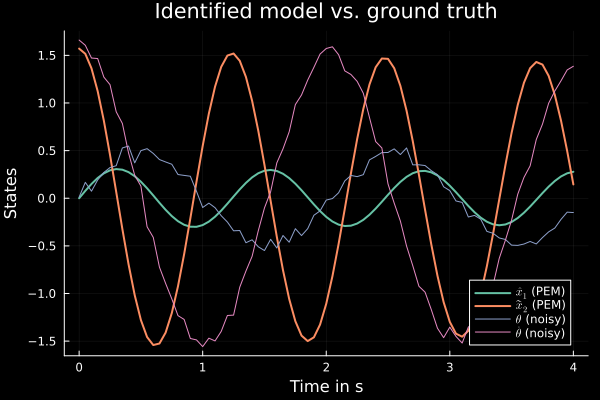

In [7]:
prob = ODEProblem(simplependulum_train_length!, x0, tspan, res.minimizer);
sol = solve(prob,Tsit5(),saveat=0.05);

x = reduce(hcat,sol.u)
plot(sol.t,x',label=[L"$\hat{x}_1$ (PEM)" L"$̂\hat{x}_2$ (PEM)"],xlabel="Time in s",ylabel="States",title="Identified model vs. ground truth", lw=2,background_color="#000000", palette = :Set2_5)
plot!(sol.t,y',label=[L"$\theta$ (noisy)" L"$\dot{\theta}$ (noisy)"])

What practical options do we have to address this **global vs. local optima challenge**?

* Multi-start: Repeat the gradient-based optimization using multiple initial guesses.
* Global heuristics: Apply optimization algorithms that do not greedily optimize for the next local optimum (such as meta heuristics).

Just for illustration purpose, let's use a [particle swarm optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization) which is also available within the [Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/#algo/particle_swarm/) package.

In [34]:
res_PSO = optimize(w -> costs(w, y, prob), [0.5], ParticleSwarm(lower = [0.01], upper = [10.0], n_particles = 10), Optim.Options(iterations = 50))

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.715539e-01

 * Found with
    Algorithm:     Particle Swarm

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    50
    f(x) calls:    560
    ∇f(x) calls:   0


In [35]:
# Print the found parameter result and compare to ground truth
println("Found parameter: ", res_PSO.minimizer)
println("Ground truth: ", L)

Found parameter: [0.9988653687053679]
Ground truth: 1.0


Next, we visualize the PSO-based result.

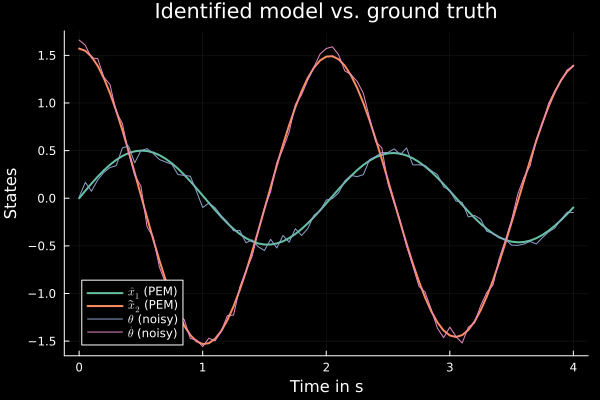

In [31]:
prob = ODEProblem(simplependulum_train_length!, x0, tspan, res_PSO.minimizer);
sol = solve(prob,Tsit5(),saveat=0.05);

x = reduce(hcat,sol.u)
plot(sol.t,x',label=[L"$\hat{x}_1$ (PEM)" L"$̂\hat{x}_2$ (PEM)"],xlabel="Time in s",ylabel="States",title="Identified model vs. ground truth", lw=2,background_color="#000000", palette = :Set2_5)
plot!(sol.t,y',label=[L"$\theta$ (noisy)" L"$\dot{\theta}$ (noisy)"])

Although the PSO was able to find the global optimum, the meta-heuristic approach comes at the expense of an increased computational effort as the search is not as streamlined as gradient descent-based methods (remember that a Newton optimization required less than 0.5 ms).

In [36]:
@benchmark res_PSO = optimize(w -> costs(w, y, prob), [0.5], ParticleSwarm(lower = [0.01], upper = [10.0], n_particles = 10), Optim.Options(iterations = 50))

BenchmarkTools.Trial: 385 samples with 1 evaluation.
 Range (min … max):   7.847 ms … 37.865 ms  ┊ GC (min … max): 0.00% … 67.47%
 Time  (median):     12.185 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.995 ms ±  4.746 ms  ┊ GC (mean ± σ):  7.11% ± 13.01%

   ▃▂  ▁ ▁▁██▁   ▁▂                                            
  ▇███▆█▇██████▆▅███▇▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▂▃▂▂▁▁▁▂▁▁▁▂▂▁▂▃▁▂▂▁▃ ▃
  7.85 ms         Histogram: frequency by time        33.4 ms <

 Memory estimate: 8.94 MiB, allocs estimate: 76443.